# ATAC MiSTR: Gene-Set Timelines For All Cell Lines

This notebook reproduces the multi-gene timeline panel style (PSC/FB/HB/MB) for every available cell line.

In [12]:
import os
os.environ['R_HOME'] = '/home/kgr851/.conda/envs/bulkATAC_RNA/lib/R'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
suppressPackageStartupMessages({
  library(tidyverse)
  library(DESeq2)
  library(readr)
  library(tibble)
})

COUNTS_FILE <- '/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/macs2/narrow_peak/consensus/consensus_peaks.mRp.clN.featureCounts.txt'
ANN_FILE <- '/datasets/renew_kirkeby/jonas/Data/Mistr_atac/251120_VH01386_221_222GHHTNX_data/PIPELINE-nfcore-atacseq/GRCh38_ensembl/bowtie2/merged_replicate/macs2/narrow_peak/consensus/consensus_peaks.mRp.clN.annotatePeaks.txt'

raw <- read_tsv(COUNTS_FILE, comment = '#', show_col_types = FALSE)
counts <- raw %>%
  select(-Geneid, -Chr, -Start, -End, -Strand, -Length) %>%
  as.matrix()
rownames(counts) <- raw$Geneid
colnames(counts) <- gsub('\\.mLb\\.clN\\.sorted\\.bam$', '', colnames(counts))

meta <- tibble(sample = colnames(counts)) %>%
  separate(sample, into = c('line','time','region','rep'), sep = '_', remove = FALSE) %>%
  mutate(across(c(line,time,region,rep), as.factor)) %>%
  as.data.frame()
rownames(meta) <- meta$sample

dds0 <- DESeqDataSetFromMatrix(countData = counts, colData = meta, design = ~ 1)
keep <- rowSums(counts(dds0) >= 10) >= 2
dds0 <- dds0[keep, ]

ann <- read_tsv(ANN_FILE, comment = '#', show_col_types = FALSE)
colnames(ann)[1] <- 'peak_id'

genes <- c('POU5F1','NANOG','OTX2','GBX2','HESX1','SHISA2','FEZF1','LHX5','DLK1','PAX6',
           'FST','HOXA1','CRABP2','CYP26A1','HOXA2','SOX1','KCNQ3','TAL2','ROR2',
           'LMO1','MEIS2','PKDCC','SEZ6','SORB2','SP5','BMP2')

ann_sub <- ann %>%
  mutate(`Gene Name` = toupper(`Gene Name`)) %>%
  filter(`Gene Name` %in% genes) %>%
  select(peak_id, `Gene Name`, `Distance to TSS`) %>%
  distinct()

dir.create('gene_traj_exports', showWarnings = FALSE, recursive = TRUE)

lines_avail <- sort(unique(as.character(colData(dds0)$line)))
all_tidy <- list()

for (ln in lines_avail) {
  message('Processing line: ', ln)

  d_line <- dds0[, dds0$line == ln]
  d_line$time   <- droplevels(d_line$time)
  d_line$region <- droplevels(d_line$region)
  d_line$line   <- droplevels(d_line$line)

  design(d_line) <- ~ 1
  d_line <- estimateSizeFactors(d_line)

  norm <- counts(d_line, normalized = TRUE) %>% as.data.frame()
  norm$peak_id <- rownames(norm)

  norm2 <- norm %>% inner_join(ann_sub, by = 'peak_id')

  meta2 <- as.data.frame(colData(d_line)) %>%
    rownames_to_column('sample_id') %>%
    transmute(
      sample_id,
      line   = as.character(line),
      time   = as.character(time),
      region = as.character(region),
      rep    = as.character(rep)
    ) %>%
    mutate(region = ifelse(toupper(region) %in% c('UNDIFF','PSC'), 'PSC', toupper(region)))

  tidy_line <- norm2 %>%
    pivot_longer(
      cols = -c(peak_id, `Gene Name`, `Distance to TSS`),
      names_to = 'sample_id',
      values_to = 'norm_count'
    ) %>%
    left_join(meta2, by = 'sample_id')

  out_line <- file.path('gene_traj_exports', paste0(ln, '_geneSet_normcounts_long_with0hPSC.csv'))
  write_csv(tidy_line, out_line)
  cat('Wrote:', out_line, '\n')

  all_tidy[[ln]] <- tidy_line
}

tidy_all <- bind_rows(all_tidy)
write_csv(tidy_all, 'gene_traj_exports/all_lines_geneSet_normcounts_long_with0hPSC.csv')
cat('Wrote: gene_traj_exports/all_lines_geneSet_normcounts_long_with0hPSC.csv\n')

print(dplyr::count(tidy_all, line, time, region) %>% dplyr::arrange(line, time, region))


Wrote: gene_traj_exports/H9_geneSet_normcounts_long_with0hPSC.csv 
Wrote: gene_traj_exports/KOLF_geneSet_normcounts_long_with0hPSC.csv 
Wrote: gene_traj_exports/RC17_geneSet_normcounts_long_with0hPSC.csv 
Wrote: gene_traj_exports/all_lines_geneSet_normcounts_long_with0hPSC.csv
# A tibble: 22 × 4
   line  time  region     n
   <chr> <chr> <chr>  <int>
 1 H9    0h    PSC      550
 2 H9    12h   FB       550
 3 H9    12h   HB       550
 4 H9    12h   MB       550
 5 H9    24h   FB       550
 6 H9    24h   HB       550
 7 H9    24h   MB       550
 8 H9    3d    FB       550
 9 H9    3d    HB       550
10 H9    3d    MB       550
# ℹ 12 more rows
# ℹ Use `print(n = ...)` to see more rows


converting counts to integer mode
Processing line: H9
Processing line: KOLF
Processing line: RC17


Saved: all_lines_pooled_bulkATAC_timeline_.png


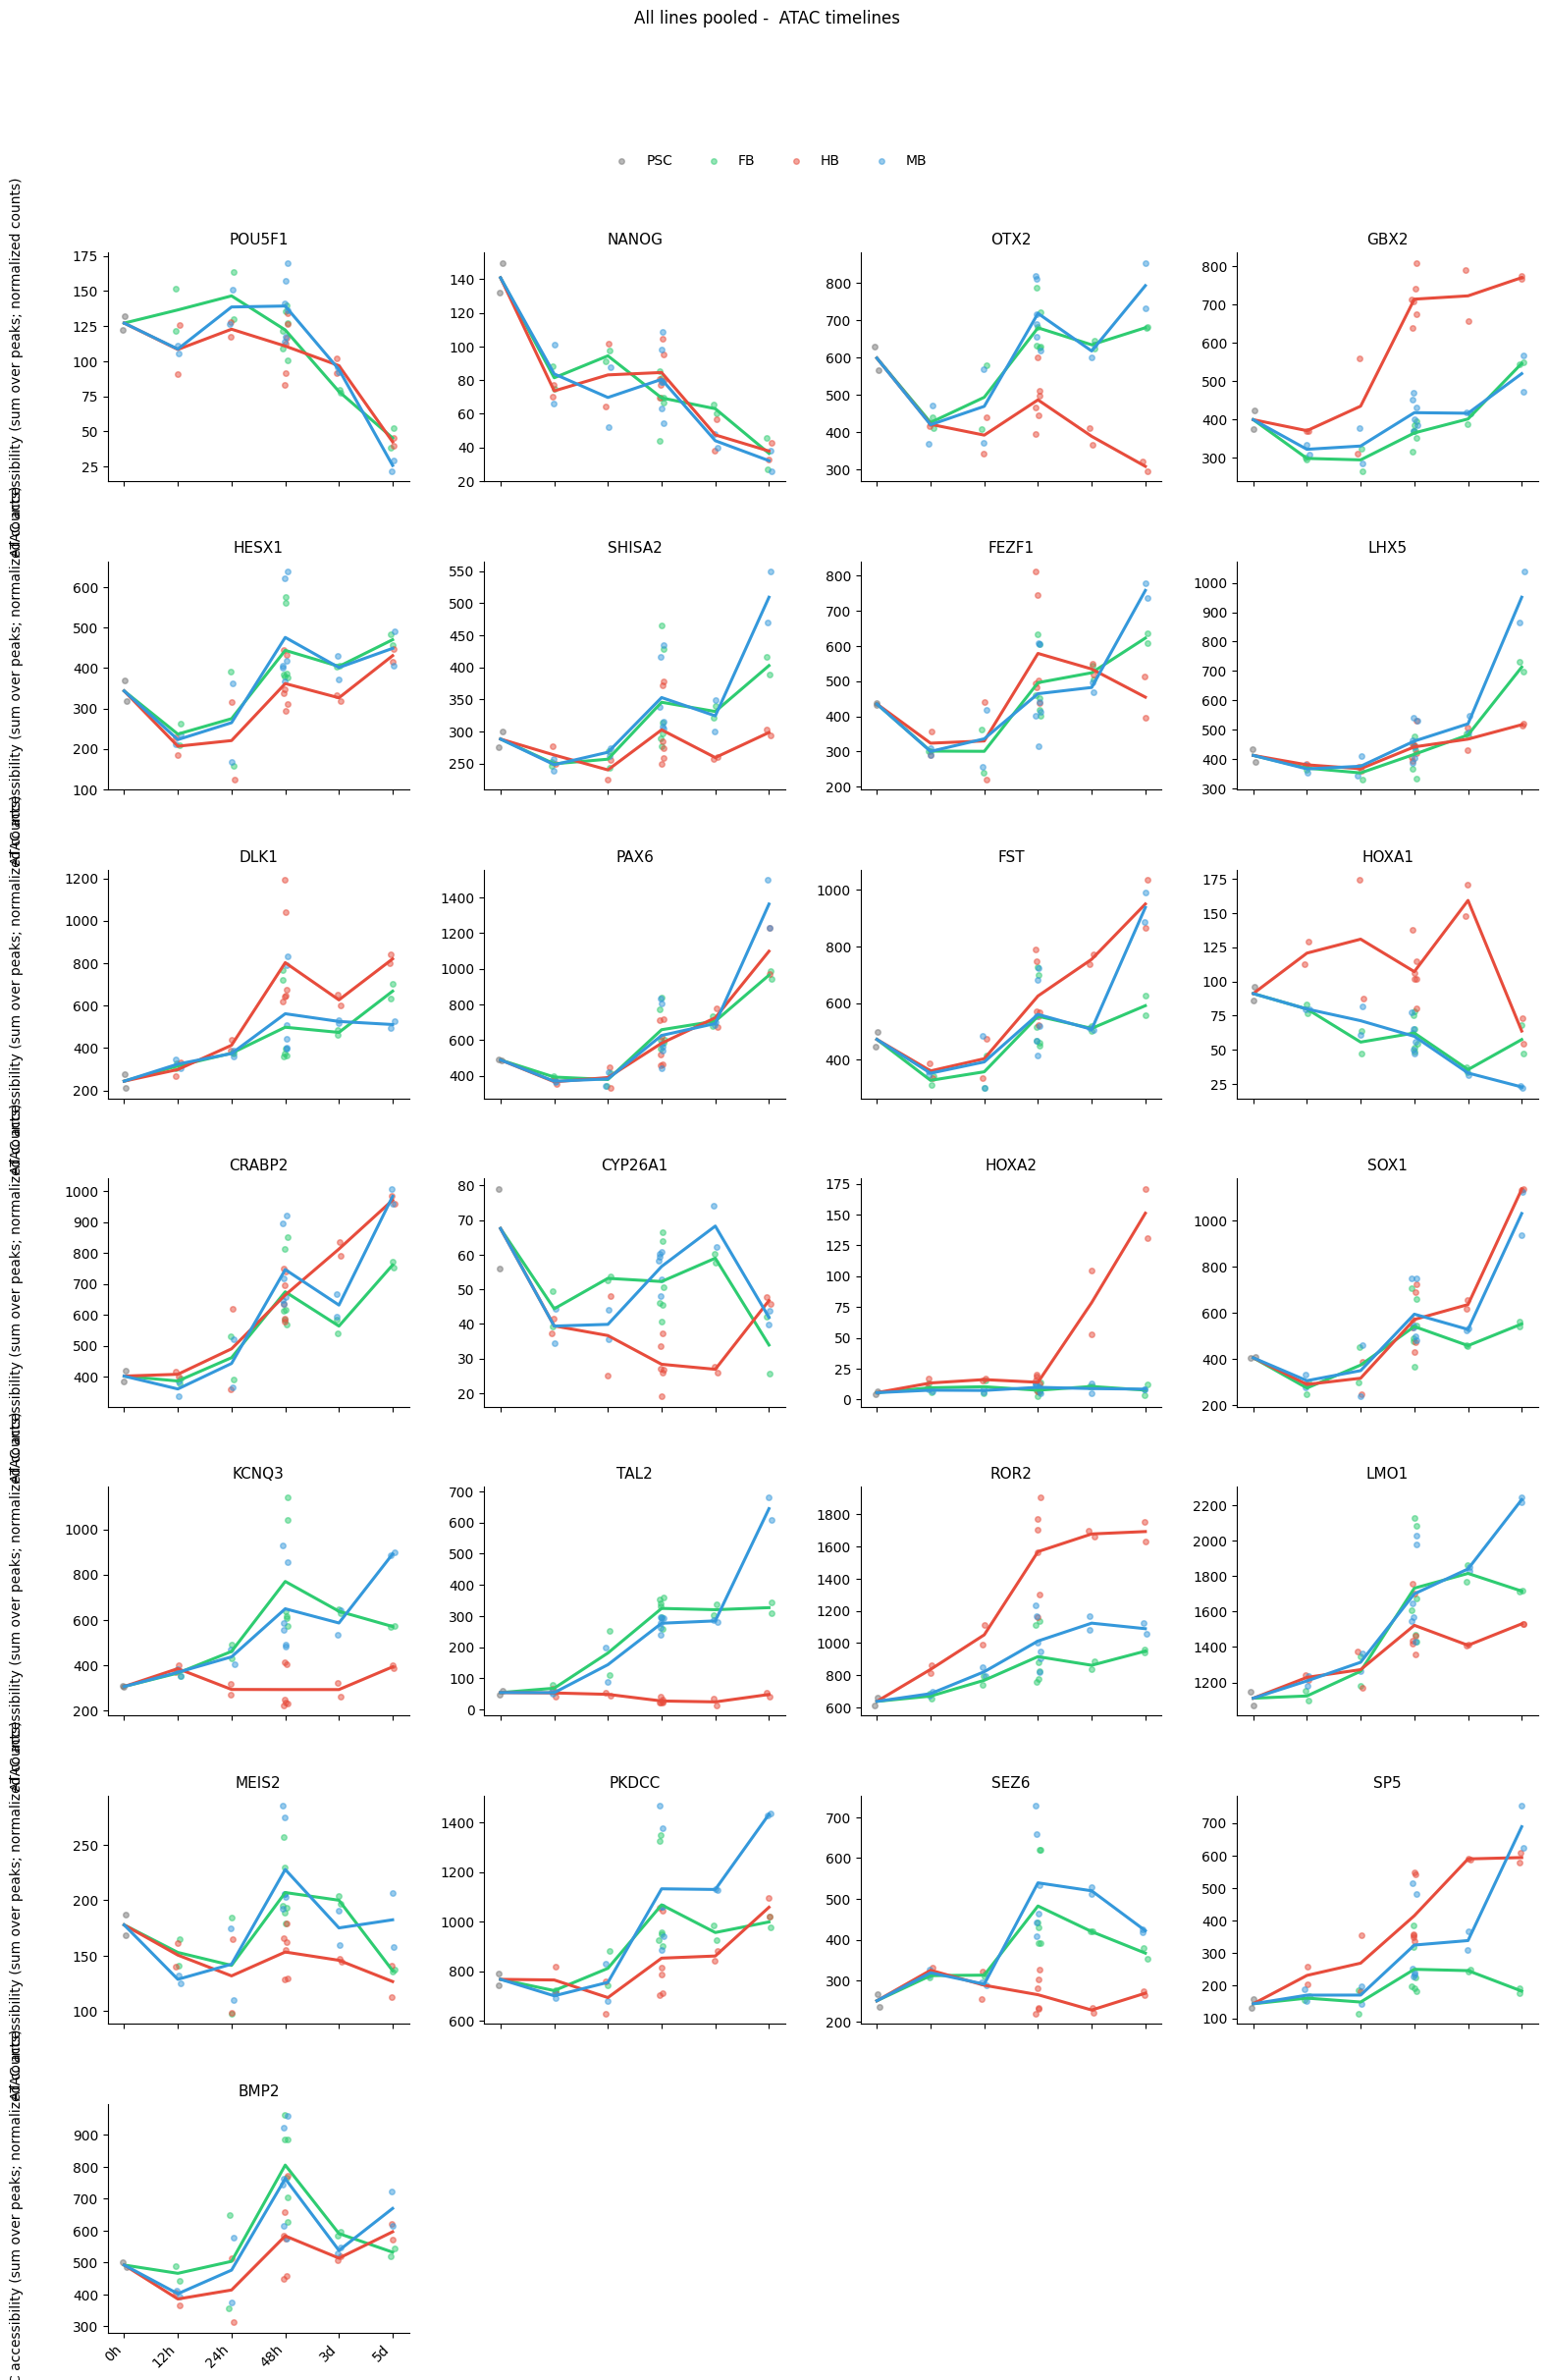

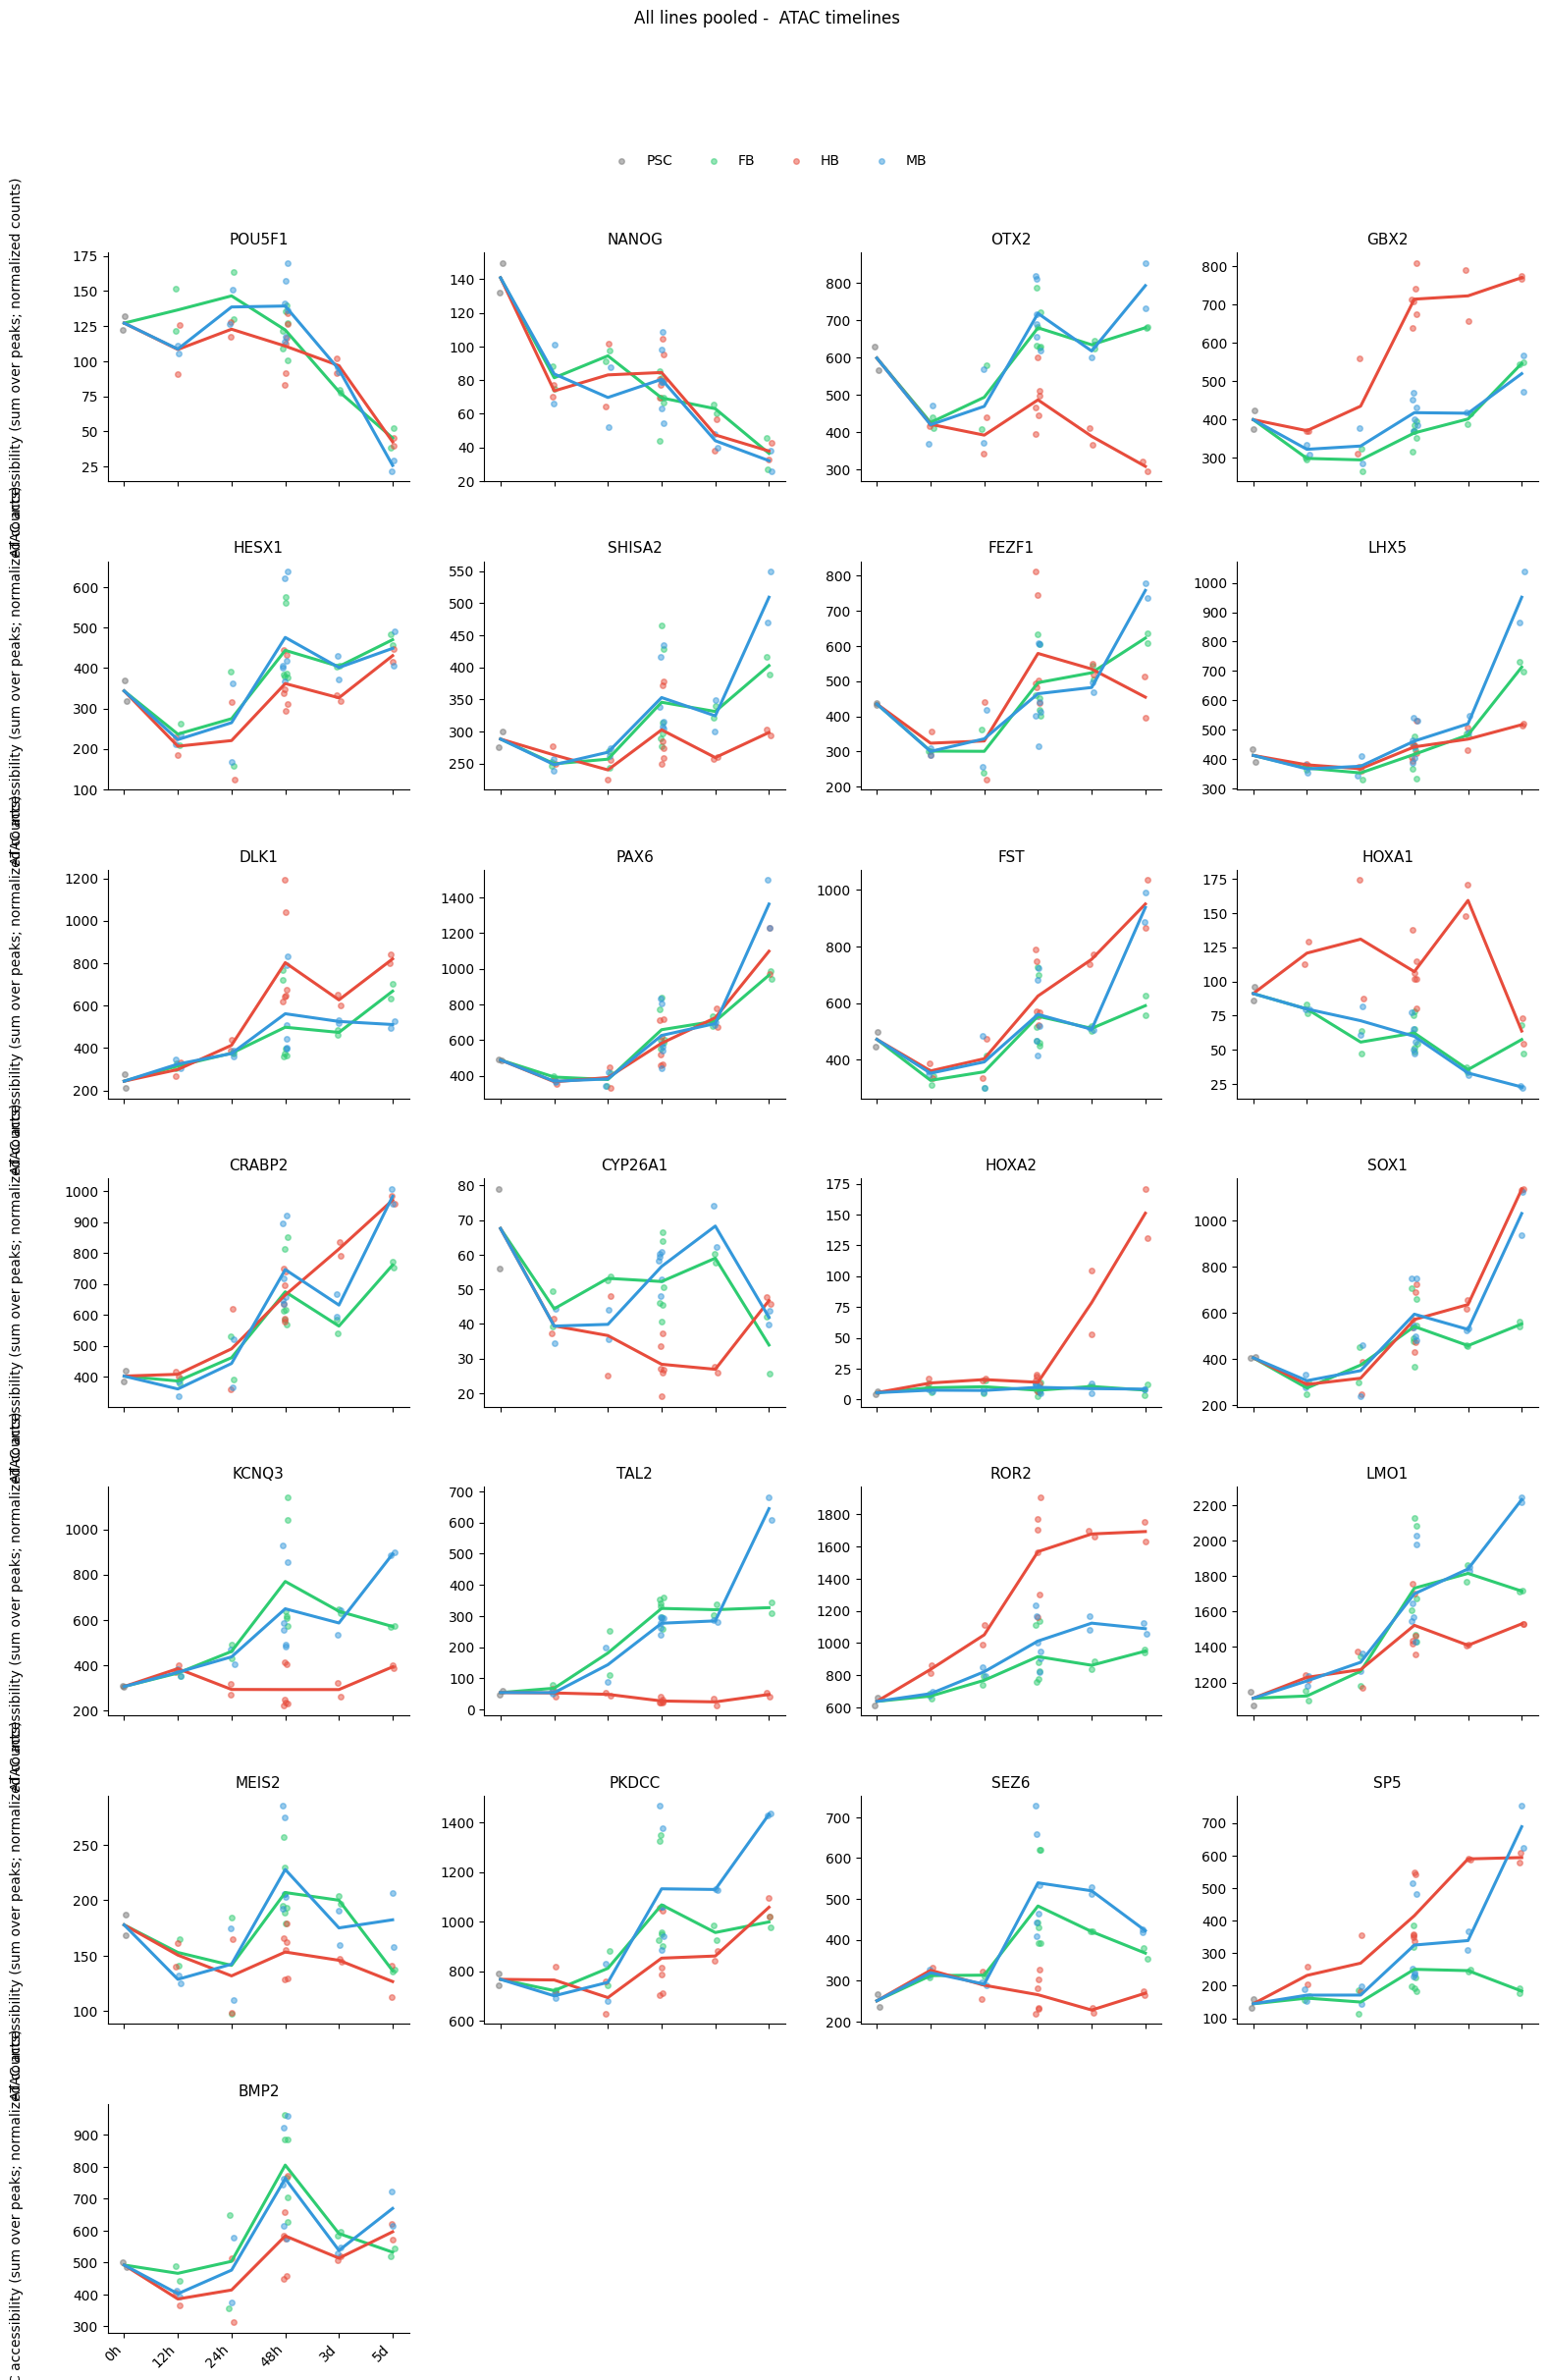

In [15]:
def plot_atac_timelines_rna_logic(
    df_plot,
    genes,
    time_order=("0h","12h","24h","48h","3d","5d"),
    fates=("PSC","FB","HB","MB"),
    points_only_fates=("PSC",),   # usually: no mean line for PSC, only points
    gene_col="Gene Name",
    time_col="time",
    fate_col="region",
    y_col="norm_count",           # in your exported CSV: normalized counts per PEAK
    peak_col="peak_id",           # (not used directly; locus collapses by summing peaks)
    sample_col="sample_id",
    ncols=4,
    figsize_per_panel=(4.0, 3.2),
    show_points=True,
    point_size=16,
    point_alpha=0.5,
    jitter=0.10,
    show_mean_lines=True,
    mean_linewidth=2.2,
    remove_grid=True,
    suptitle=None,
    save_path=None,
    random_seed=0,
    fate_colors=None,
    # --- NEW (same as RNA logic) ---
    anchor_lines_to_undiff_0h=True,     # extend FB/HB/MB lines to 0h using PSC mean at 0h
    undiff_names=("PSC","UNDIFF","UNDIFFERENTIATED"),
    # --- axis-label overlap fix ---
    y_label="ATAC accessibility (sum over peaks; normalized counts)",
    ylabel_only_leftcol=True,
):
    """
    RNA-style small multiples for bulk ATAC.

    Input df_plot is a long table with columns like:
      peak_id, Gene Name, sample_id, norm_count, time, region, ...

    What it plots:
      - For each gene: locus accessibility per sample = SUM(norm_count over all peaks for that gene)
      - Points: each sample replicate (with jitter on categorical timepoints)
      - Mean lines: mean across replicates per fate per time (skips points_only_fates)
      - Optional anchoring: prepend (0h, PSC_mean_at_0h) to FB/HB/MB mean lines
        so lines visually “start” from 0h baseline like your RNA plot.

    IMPORTANT:
      - This does NOT invent FB/HB/MB 0h points. It only anchors the MEAN line start.
      - If PSC at 0h is missing for a gene, anchoring is skipped for that gene.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    rng = np.random.default_rng(random_seed)

    # Fixed default colors (match your manuscript choices)
    if fate_colors is None:
        fate_colors = {
            "PSC": "0.35",      # grey
            "FB": "#2ca02c",    # green
            "HB": "#d62728",    # red
            "MB": "#1f77b4",    # blue
        }

    d0 = df_plot.copy()

    # normalize casing
    d0[gene_col] = d0[gene_col].astype(str).str.upper()
    d0[time_col] = d0[time_col].astype(str)
    d0[fate_col] = d0[fate_col].astype(str).str.upper()

    genes = [str(g).upper() for g in genes]
    fates = tuple([str(f).upper() for f in fates])
    points_only_fates = tuple([str(p).upper() for p in points_only_fates])

    # filter
    d0 = d0[d0[fate_col].isin(list(fates))].copy()
    d0 = d0[d0[time_col].isin(list(time_order))].copy()
    d0 = d0[d0[gene_col].isin(genes)].copy()
    if d0.empty:
        raise ValueError("No rows left after filtering. Check genes / fates / time_order.")

    # ------------------------------------------------------------
    # 1) collapse peaks -> locus accessibility per sample
    #    (gene, time, fate, sample) = sum over peaks
    # ------------------------------------------------------------
    locus = (
        d0.groupby([gene_col, time_col, fate_col, sample_col], as_index=False)[y_col]
          .sum()
          .rename(columns={y_col: "locus_access"})
    )

    # ordered categorical time for stable plotting + jitter coding
    locus[time_col] = pd.Categorical(
        locus[time_col].astype(str),
        categories=list(time_order),
        ordered=True
    )
    time_to_x = {t: i for i, t in enumerate(list(time_order))}

    points_only_lower = set([p.lower() for p in points_only_fates])
    undiff_lower = set([u.lower() for u in undiff_names])

    # mean per fate/time (and per gene)
    means = None
    if show_mean_lines:
        means = (
            locus.groupby([gene_col, fate_col, time_col], observed=True)["locus_access"]
                 .mean()
                 .reset_index()
        )

    # layout
    n = len(genes)
    ncols = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0] * ncols, figsize_per_panel[1] * nrows),
        sharex=True,
    )
    axes = np.array(axes).reshape(-1)

    # ------------------------------------------------------------
    # 2) plot each gene panel
    # ------------------------------------------------------------
    for i, (ax, g) in enumerate(zip(axes, genes)):
        dg = locus[locus[gene_col] == g].copy()

        # points (replicates)
        if show_points:
            for fate in fates:
                sub = dg[dg[fate_col] == fate]
                if sub.empty:
                    continue
                x = sub[time_col].cat.codes.to_numpy()
                x = x + (rng.random(len(x)) - 0.5) * float(jitter)

                ax.scatter(
                    x,
                    sub["locus_access"].values,
                    s=point_size,
                    alpha=point_alpha,
                    color=fate_colors.get(str(fate), None),
                    label=str(fate),
                    zorder=2,
                )

        # mean lines (skip points-only fates, e.g. PSC)
        if show_mean_lines and means is not None:
            mg = means[means[gene_col] == g].copy()

            # compute PSC mean at 0h for anchoring (single number)
            undiff_y = None
            if anchor_lines_to_undiff_0h:
                und = mg[
                    (mg[fate_col].astype(str).str.lower().isin(undiff_lower)) &
                    (mg[time_col].astype(str) == "0h")
                ]
                if len(und):
                    undiff_y = float(und["locus_access"].iloc[0])

            for fate in fates:
                if str(fate).lower() in points_only_lower:
                    continue  # no line for PSC

                mf = mg[mg[fate_col] == fate].copy()
                if mf.empty:
                    continue

                mf["x"] = mf[time_col].map(time_to_x)
                mf = mf.sort_values("x")

                xs = mf["x"].to_numpy()
                ys = mf["locus_access"].to_numpy()

                # ANCHOR: prepend (0h, PSC_mean) if fate doesn't have 0h
                if undiff_y is not None and "0h" in time_to_x:
                    x0 = time_to_x["0h"]
                    if len(xs) == 0 or xs[0] != x0:
                        xs = np.insert(xs, 0, x0)
                        ys = np.insert(ys, 0, undiff_y)

                if len(xs) < 2:
                    continue

                # connect only adjacent timepoints that exist
                start = 0
                for k in range(1, len(xs)):
                    if xs[k] != xs[k - 1] + 1:
                        ax.plot(
                            xs[start:k],
                            ys[start:k],
                            linewidth=mean_linewidth,
                            color=fate_colors.get(str(fate), None),
                            zorder=3,
                        )
                        start = k

                ax.plot(
                    xs[start:],
                    ys[start:],
                    linewidth=mean_linewidth,
                    color=fate_colors.get(str(fate), None),
                    zorder=3,
                )

        # title
        ax.set_title(str(g), fontsize=11)

        # y-label overlap fix: only left column gets label
        if ylabel_only_leftcol:
            col_idx = i % ncols
            if col_idx == 0:
                ax.set_ylabel(y_label)
                ax.yaxis.set_label_coords(-0.28, 0.5)
            else:
                ax.set_ylabel("")
        else:
            ax.set_ylabel(y_label)
            ax.yaxis.set_label_coords(-0.28, 0.5)

        # clean style
        ax.grid(False if remove_grid else True)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # turn off unused axes
    for ax in axes[len(genes):]:
        ax.axis("off")

    # x ticks (categorical labels like RNA)
    xticks = np.arange(len(time_order))
    for ax in axes[:len(genes)]:
        ax.set_xticks(xticks)
        ax.set_xticklabels(list(time_order), rotation=45, ha="right")

    # legend once (unique labels)
    handles, labels = axes[0].get_legend_handles_labels()
    seen = set()
    uniq_h, uniq_l = [], []
    for h, lab in zip(handles, labels):
        if lab not in seen:
            uniq_h.append(h)
            uniq_l.append(lab)
            seen.add(lab)

    if uniq_h:
        fig.legend(
            uniq_h,
            uniq_l,
            frameon=False,
            loc="upper center",
            ncol=min(len(uniq_l), 6),
            bbox_to_anchor=(0.5, 1.02),
        )

    if suptitle:
        fig.suptitle(suptitle, y=1.08)

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, wspace=0.25, hspace=0.35)

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print("Saved:", save_path)

    plt.show()
    return fig


# -----------------------
# Usage on all-lines CSV
# -----------------------
import pandas as pd

CSV = "gene_traj_exports/all_lines_geneSet_normcounts_long_with0hPSC.csv"
df = pd.read_csv(CSV)

genes = [
    "POU5F1","NANOG","OTX2","GBX2","HESX1","SHISA2","FEZF1","LHX5","DLK1","PAX6",
    "FST","HOXA1","CRABP2","CYP26A1","HOXA2","SOX1","KCNQ3","TAL2","ROR2", "LMO1","MEIS2","PKDCC","SEZ6","SP5","BMP2"
]

plot_atac_timelines_rna_logic(
    df_plot=df,
    genes=genes,
    time_order=("0h","12h","24h","48h","3d","5d"),
    fates=("PSC","FB","HB","MB"),
    points_only_fates=("PSC",),
    anchor_lines_to_undiff_0h=True,
    undiff_names=("PSC","UNDIFF","UNDIFFERENTIATED"),
    fate_colors={"PSC":"0.45","FB":"#2ecc71","HB":"#e74c3c","MB":"#3498db"},
    ncols=4,
    figsize_per_panel=(4.0, 3.2),
    suptitle="All lines pooled -  ATAC timelines",
    save_path="all_lines_pooled_bulkATAC_timeline_.png",
)

